---
title: "Surrogate Model-Based Multi-Objective Optimization Using Desirability Functions"
author: "Thomas Bartz-Beielstein"
date: "15 July 2025"
format:
  beamer:
    theme: gotham
    aspectratio: 169
    navigation: horizontal
    section-titles: false
    slide-number: true
    background-image: ""
    runninghead: "MO Optimization and HPT With Desirability Functions"
    include-in-header:
        - text: |
            \usepackage{url}
            \usetheme{gotham}
            \usecolortheme{seahorse}
            \gothamset{background=light}
            \gothamset{block=transparent}
            \gothamset{numbering=pagenumber}
            \gothamset{sectiontocframe default=off}
bibliography: references.bib
---


In [1]:
import os
from math import inf
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from spotpython.hyperparameters.values import set_hyperparameter
from spotpython.data.diabetes import Diabetes
from spotpython.fun.mohyperlight import MoHyperLight
from spotpython.hyperdict.light_hyper_dict import LightHyperDict
from spotpython.hyperparameters.values import set_hyperparameter
from spotpython.mo.functions import fun_myer16a
from spotpython.mo.plot import plot_mo
from spotpython.plot.contour import (mo_generate_plot_grid, contour_plot,
                                     contourf_plot)
from spotpython.utils.eda import print_exp_table, print_res_table
from spotpython.utils.file import get_experiment_filename
from spotpython.spot import Spot
from spotpython.utils.init import (fun_control_init, surrogate_control_init,
                                   design_control_init)
from spotdesirability.utils.desirability import (DOverall, DMax, DCategorical, DMin,
                                                 DTarget, DArb, DBox)
from spotdesirability.plot.ccd import plotCCD
from spotdesirability.functions.rsm import rsm_opt, conversion_pred, activity_pred
warnings.filterwarnings("ignore")

Seed set to 123


# Introduction & Motivation

## Motivation from Industry

- **The Dichotomy:** Significant gap between industrial adoption and academic use
  - Desirability functions (Harrington, 1965): Established in industrial optimization
  - Seldom used in academic multi-objective optimization (MOO)
  - (Never?) used in ML/hyperparameter tuning (HPT)

- **The Problem in ML/DL HPT:** Manual, irreproducible trial-and-error processes
  - Balancing model accuracy, training time, complexity
  - Lack of systematic multi-objective approaches

- **Background:** This work is motivated by requests from industrial partners:
  - "Confused" by the Pareto-front concepts

- **Our Aim:** Providing easy to use tools



## Core Research Questions

1. **Application:** How can desirability functions be methodically used for:
   - Classical multi-objective optimization
   - Contemporary hyperparameter tuning

2. **Long-term Goal:** What are the concrete advantages and disadvantages compared to other MOO methods?

3. **Enhancement:** How can the desirability framework be improved to overcome known limitations?

## Materials

### Jupyter Notebook

* Updates and Jupyter Notebook of this Presentation:
    * Research Cluster "Technische Hochschule Köln - Artificial Intelligence"
    * [https://thk-ai.de](https://thk-ai.de)

# Theoretical Foundation

## The Desirability Function: Fundamentals

:::: {.columns}

::: {.column width="50%"}
### Core Concept
- Transform multiple **incommensurable objectives** $f_r(x)$
- Single **dimensionless scale** $d_r \in [0,1]$
- 0 = completely unacceptable
- 1 = perfectly desirable
:::

::: {.column width="50%"}
### Three Function Types

- **Larger-is-Better ($d_{\max}$):** Maximization (accuracy, yield)
- **Smaller-is-Better ($d_{\min}$):** Minimization (error, cost)  
- **Target-is-Best ($d_{\text{target}}$):** Specific target value
:::

::::

## Maximization Formula


### Maximization

* For maximization of $f_r(\vec{x})$ ("larger-is-better"), the following function is used:

$$
d_r^{\text{max}} =
\begin{cases}
    0 & \text{if } f_r(\vec{x}) < A \\
    \left(\frac{f_r(\vec{x}) - A}{B - A}\right)^s & \text{if } A \leq f_r(\vec{x}) \leq B \\
    1 & \text{if } f_r(\vec{x}) > B
\end{cases}
$$

* Parameters $A$ ("acceptable"), $B$ ("ideal"), and $s$ ("scale") are chosen by the investigator.
* Similar in the minimization case ("smaller-is-better").
* Scale parameter $s$ can be adjusted to make the desirability criterion easier or harder to satisfy.

## Target

### Target Optimization

* Target value: $t_0$.
* In "target-is-best" situations, the following function is used:

$$
d_r^{\text{target}} =
\begin{cases}
    \left(\frac{f_r(\vec{x}) - A}{t_0 - A}\right)^{s_1} & \text{if } A \leq f_r(\vec{x}) \leq t_0 \\
    \left(\frac{f_r(\vec{x}) - B}{t_0 - B}\right)^{s_2} & \text{if } t_0 \leq f_r(\vec{x}) \leq B \\
    0 & \text{otherwise.}
\end{cases}
$$



## Visualization of Desirability Functions

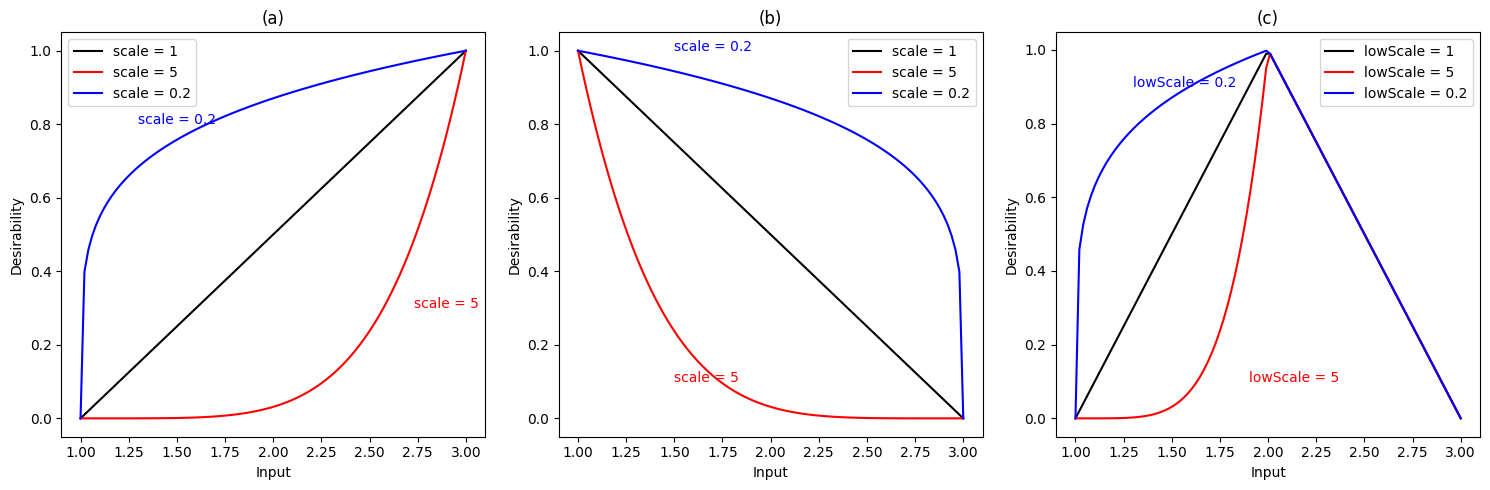

In [2]:
#| echo: false
#| label: fig-kuhn16a-1
#| fig-cap: "Examples of the three primary desirability functions. Panel (a) Larger--is--better function, panel (b) Smaller--is--better desirability function and panel (c) target value."

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# (a) Plot for DMax
axes[0].set_title("(a)")
dmax1 = DMax(1, 3)
dmax2 = DMax(1, 3, scale=5)
dmax3 = DMax(1, 3, scale=1/5)

# Plot DMax with scale=1
x = np.linspace(dmax1.low, dmax1.high, 100)
y = dmax1.predict(x)
axes[0].plot(x, y, label="scale = 1", color="black")

# Plot DMax with scale=5
y2 = dmax2.predict(x)
axes[0].plot(x, y2, label="scale = 5", color="red")
axes[0].text(2.73, 0.3, "scale = 5", color="red")

# Plot DMax with scale=0.2
y3 = dmax3.predict(x)
axes[0].plot(x, y3, label="scale = 0.2", color="blue")
axes[0].text(1.3, 0.8, "scale = 0.2", color="blue")

axes[0].set_xlabel("Input")
axes[0].set_ylabel("Desirability")
axes[0].legend()

# (b) Plot for DMin
axes[1].set_title("(b)")
dmin1 = DMin(1, 3)
dmin2 = DMin(1, 3, scale=5)
dmin3 = DMin(1, 3, scale=1/5)

# Plot DMin with scale=1
y = dmin1.predict(x)
axes[1].plot(x, y, label="scale = 1", color="black")

# Plot DMin with scale=5
y2 = dmin2.predict(x)
axes[1].plot(x, y2, label="scale = 5", color="red")
axes[1].text(1.5, 0.1, "scale = 5", color="red")

# Plot DMin with scale=0.2
y3 = dmin3.predict(x)
axes[1].plot(x, y3, label="scale = 0.2", color="blue")
axes[1].text(1.5, 1, "scale = 0.2", color="blue")

axes[1].set_xlabel("Input")
axes[1].set_ylabel("Desirability")
axes[1].legend()

# (c) Plot for DTarget
axes[2].set_title("(c)")
dtarget1 = DTarget(1, 2, 3)
dtarget2 = DTarget(1, 2, 3, low_scale=5)
dtarget3 = DTarget(1, 2, 3, low_scale=1/5)

# Plot DTarget with low_scale=1
y = dtarget1.predict(x)
axes[2].plot(x, y, label="lowScale = 1", color="black")

# Plot DTarget with low_scale=5
y2 = dtarget2.predict(x)
axes[2].plot(x, y2, label="lowScale = 5", color="red")
axes[2].text(1.9, 0.1, "lowScale = 5", color="red")

# Plot DTarget with low_scale=0.2
y3 = dtarget3.predict(x)
axes[2].plot(x, y3, label="lowScale = 0.2", color="blue")
axes[2].text(1.3, 0.9, "lowScale = 0.2", color="blue")

axes[2].set_xlabel("Input")
axes[2].set_ylabel("Desirability")
axes[2].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Parameters

### Larger is Harder

The values of $s$, $s_1$, or $s_2$ can be chosen so that the desirability criterion is easier or more difficult to satisfy (examples on the next slides):


* Values of $s$ **greater than 1** will make $d_r^{\text{max}}$ **harder to satisfy** in terms of desirability.
    * If $s$ is chosen to be less than 1 in $d_r^{\text{max}}$, $d_r^{\text{max}}$ is near 1 even if  $f_r(\vec{x})$ is not low.
    * As values of $s$ move closer to 0, the desirability reflected by $d_r^{\text{max}}$ becomes higher.


* Scaling factors are useful when one equation holds more importance than others.
* Any function can reflect model desirability.



## Examples: Parametrization

### Maximization for s=0.5 and s=5

:::: {.columns}

::: {.column width="50%"}

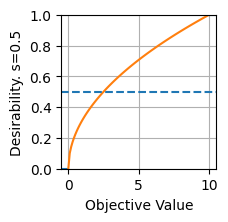

In [3]:
#| echo: false
dMax_obj = DMax(low=0, high=10, missing=0.5, scale=0.5)
dMax_obj.plot(figsize=(2, 2), xlabel="Objective Value", ylabel="Desirability. s=0.5")

:::

::: {.column width="50%"}


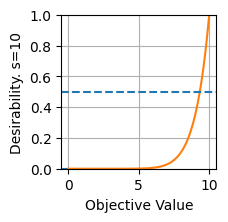

In [4]:
#| echo: false
dMax_obj = DMax(low=0, high=10, missing=0.5, scale=10, tol=None)
dMax_obj.plot(figsize=(2, 2), xlabel="Objective Value", ylabel="Desirability. s=10")

:::

::::

* Dotted blue lines: desirability where objective value cannot be computed (`NA`s)

## Target Desirability

### Target-is-Best

:::: {.columns}

::: {.column width="50%"}

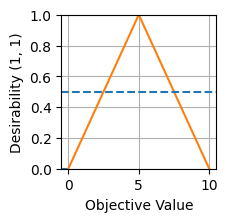

In [5]:
#| echo: false
dTarget_obj = DTarget(low=0, high=10, target=5, missing=0.5, low_scale=1, high_scale=1)
dTarget_obj.plot(figsize=(2, 2), xlabel="Objective Value", ylabel="Desirability (1, 1)")

:::

::: {.column width="50%"}

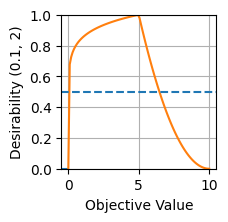

In [6]:
#| echo: false
dTarget_obj = DTarget(low=0, high=10, target=5, missing=0.5, low_scale=.1, high_scale=2)
dTarget_obj.plot(figsize=(2, 2), xlabel="Objective Value", ylabel="Desirability (0.1, 2)")

:::

::::



## Zero-Desirability Tolerances

### Zero-Desirability Problem

* In high-dimensional MOO outcomes, finding feasible solutions where every desirability value is acceptable can be challenging.
* Each desirability R function has a `tol` argument, which can be set between [0, 1] (default is `NULL`).
* If not null, zero desirability values are replaced by `tol`.
* Research Question:
    * Using a default, small value for `tol` can be usefull (similar to the $\lambda$  nugget in Kriging).



## Custom or Arbitary Desirability Functions 

The `dArb` function (`Arb` stands for "Arbitary") can be used to create a custom desirability function.

### Example: Logistic Desirability Function

* The logistic function defined as 
$$
d(\vec{x}) = \frac{1}{1+\exp(-\vec{x})}.
$$
* Inputs in-between these grid points are linearly interpolated. 

In [7]:
#| label: kuhn16a-logistic
#| echo: true
def logistic(u):
    return 1 / (1 + np.exp(-u))
x = np.linspace(-5, 5, 20)
logistic_d = DArb(x, logistic(x))

## Plotting the Logistic Desirability Function

*  @fig-kuhn16a-7 displays a `plot` of the `logisticD` object.

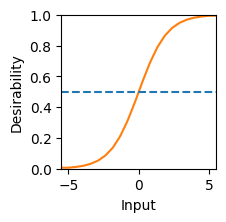

In [8]:
#| label: fig-kuhn16a-7
#| fig-cap: "Using the `DArb` function. The desirability function is a logistic curve."
logistic_d.plot(figsize=(2, 2), xlabel="Input", ylabel="Desirability")

## Overall Desirability and "Veto" Property

### Aggregation Formula
$$D = \left(\prod_{r=1}^{R} d_r\right)^{1/R}$$

- **Geometric mean** ensures the "veto" property:
    - **If any $d_r = 0$, then $D = 0$**
- All objectives must meet minimal acceptability
- Translates specification limits into **hard constraints**


# Case Study 1: Validation and Verification

## How to Validate and Verify the Software Package?

### Testing the Package
* `pytest`

### Comparison with Existing R Packages

* Validate `spotdesirability` on classic RSM problem (quadratic response surface model) [@Myers2016].
* R package `desirability` is used for comparison.


### Methods Compared

- Direct Search (Nelder-Mead):
    - R: `desirability` with `optim` with `method="Nelder-Mead"`
    - Python: `spotdesirability` with `scipy.optimize.minimize` with `method="Nelder-Mead"`

In addition: **Surrogate-Model Based Optimization (SMBO)**

## Validating and Verifying by Comparing to R Package

### Chemical Reaction Optimization

* Well-studied optimization problem from @Myers2016.
* Study based on the work of @kuhn16a.
* Three input variables normalized to $[-1, 1]$:
    * $x_1$: Time (hours), 
    * $x_2$: Temperature (°C), and
    * $x_3$: Catalyst concentration (g/L)

## Chemical Reaction Optimization

### Two Objectives
- **Maximize Percent Conversion:** $d_{\max}$ (80% min, 97% target)
- **Target Thermal Activity:** $d_{\text{target}}$ (55-60 range, 57.5 ideal)

\begin{align*}
f_{\text{con}}(x) =
&
 81.09
+
1.0284 \cdot x_1
+
4.043 \cdot x_2
+
6.2037 \cdot x_3
+
1.8366 \cdot x_1^2
+
2.9382 \cdot x_2^2 \\
&
+
5.1915 \cdot x_3^2
+
2.2150 \cdot x_1 \cdot x_2
+
11.375 \cdot x_1 \cdot x_3
+
3.875 \cdot x_2 \cdot x_3\\
f_{\text{act}}(x) = 
 & 
 59.85
+ 3.583 \cdot x_1
+ 0.2546 \cdot x_2
+ 2.2298 \cdot x_3
+ 0.83479 \cdot x_1^2
+ 0.07484 \cdot x_2^2
\\
&
+ 0.05716 \cdot x_3^2
+ 0.3875 \cdot x_1 \cdot x_2
+ 0.375 \cdot x_1 \cdot x_3
+ 0.3125 \cdot x_2 \cdot x_3. 
\end{align*}


In [9]:
#| label: kuhn16a-conversion
#| echo: false

def conversion_pred(x):
    return (
        81.09
        + 1.0284 * x[0]
        + 4.043 * x[1]
        + 6.2037 * x[2]
        - 1.8366 * x[0]**2
        + 2.9382 * x[1]**2
        - 5.1915 * x[2]**2
        + 2.2150 * x[0] * x[1]
        + 11.375 * x[0] * x[2]
        - 3.875 * x[1] * x[2]
    )

def activity_pred(x):
    return (
        59.85
        + 3.583 * x[0]
        + 0.2546 * x[1]
        + 2.2298 * x[2]
        + 0.83479 * x[0]**2
        + 0.07484 * x[1]**2
        + 0.05716 * x[2]**2
        - 0.3875 * x[0] * x[1]
        - 0.375 * x[0] * x[2]
        + 0.3125 * x[1] * x[2]
    )

In [10]:
#| echo: false
variables = {
    "time": (-1.7, 1.7),
    "temperature": (-1.7, 1.7),
    "catalyst": (-1.7, 1.7)
}
resolutions = {
    "time": 50,
    "temperature": 2,
    "catalyst": 50
}
functions = {
    "conversionPred": conversion_pred,
    "activityPred": activity_pred
}
plot_grid = mo_generate_plot_grid(variables, resolutions, functions)

## Case Study 1: The response surface for the percent conversion model

### Objective 1: Maximize Percent Conversion

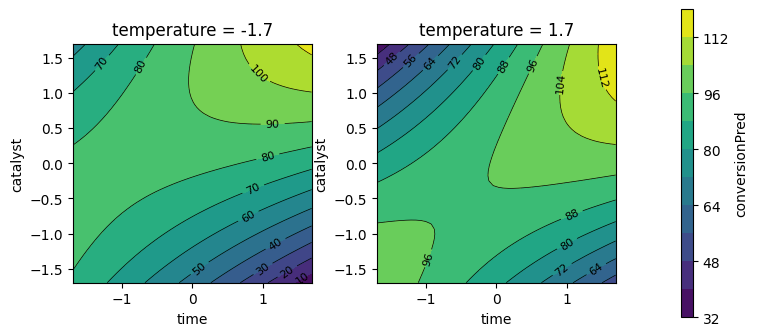

In [11]:
#| echo: false
#| label: fig-kuhn16a-2

contourf_plot(
    plot_grid,
    x_col="time",
    y_col="catalyst",
    z_col="conversionPred",
    facet_col="temperature",
)

## Case Study 1: The response surface for the thermal activity model

### Objective 2: Target Thermal Activity

In [12]:
#| label: fig-kuhn16a-3
contourf_plot(
    plot_grid,
    x_col="time",
    y_col="catalyst",
    z_col="activityPred",
    facet_col="temperature",
)

## Package Installation

### `spotdesirability` Python Package

* Available on GitHub [https://github.com/sequential-parameter-optimization/spotdesirability](https://github.com/sequential-parameter-optimization/spotdesirability) and 
* on PyPi [https://pypi.org/project/spotdesirability](https://pypi.org/project/spotdesirability) 
* It can be installed via `pip install spotdesirability`


## Defining the Desirability Functions 

### Larger-is-Better and Target Desirability

* A larger-is-better function ($d_r^{\text{max}}$) is used for percent conversion with values $A = 80$ and $B = 97$.
* A target-oriented desirability function ($d_r^{\text{target}}$) was used for thermal activity with $t_0 = 57.5$, $A = 55$, and $B = 60$.

### Creating Desirability Objects

* The two desirability objects can be created as follows:

In [13]:
#| label: kuhn16a-desirability-obj
#| echo: true
conversionD = DMax(80, 97)
activityD = DTarget(55, 57.5, 60)
overallD = DOverall(conversionD, activityD)

## Predicting Desirability Values

#### Computing Desirability at the Center Point

* Predict the desirability for the center point of the experimental design.
* Overall desirability computed using the `DOverall` class.
* Based on these desirability predictions, contour plots can be generated to visualize the desirability surfaces.

In [14]:
#| label: kuhn16a-desirability-predict-tree
# Objective values at the center point
pred_outcomes = [
    conversion_pred([0, 0, 0]),
    activity_pred([0, 0, 0])
]
overall_desirability = overallD.predict(pred_outcomes, all=True)
print("Conversion Desirability:", overall_desirability[0][0])
print("Activity Desirability:", overall_desirability[0][1])
print("Overall Desirability (geom. mean):", overall_desirability[1])

Conversion Desirability: [0.06411765]
Activity Desirability: [0.06]
Overall Desirability (geom. mean): [0.06202466]


In [15]:
#| label: kuhn16a-desirability-all-true
#| echo: false
d_values = overallD.predict(plot_grid.iloc[:, [3, 4]].values, all=True)
individual_desirabilities = d_values[0]
overall_desirability = d_values[1]
d_values_df = pd.DataFrame(individual_desirabilities).T  
d_values_df.columns = ["D1", "D2"]
d_values_df["Overall"] = overall_desirability
plot_grid = pd.concat([plot_grid, d_values_df], axis=1)

## First Objective: Individual Desirability Surface

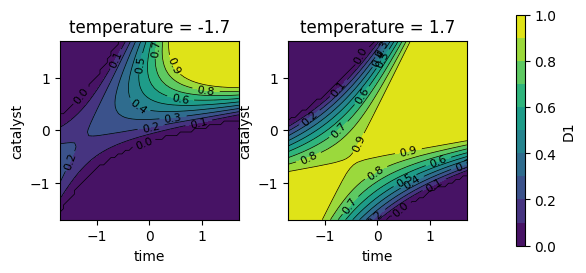

In [16]:
#| echo: false
#| label: fig-kuhn16a-4
contourf_plot(
    data=plot_grid,
    x_col='time',
    y_col='catalyst',
    z_col='D1',
    facet_col='temperature',
    aspect=1,
    as_table=True,
    figsize=(3,3)
)

## Second Objective: Individual Desirability Surface

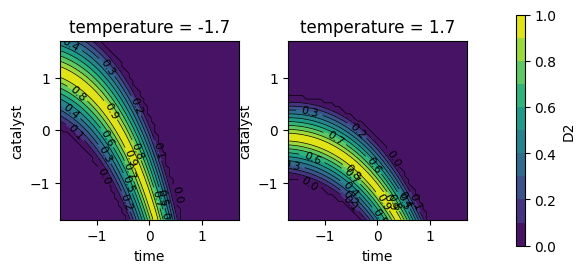

In [17]:
#| label: fig-kuhn16a-5
contourf_plot(
    data=plot_grid,
    x_col='time',
    y_col='catalyst',
    z_col='D2',
    facet_col='temperature',
    aspect=1,
    as_table=True,
    figsize=(3,3)
)

## Overall Desirability Surface

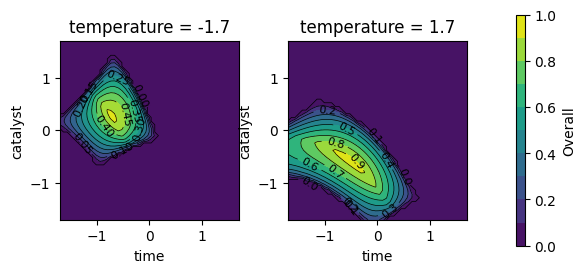

In [18]:
#| label: fig-kuhn16a-6
contourf_plot(
    data=plot_grid,
    x_col='time',
    y_col='catalyst',
    z_col='Overall',
    facet_col='temperature',
    aspect=1,
    as_table=True,
    figsize=(3,3)
)

## Optimizing the (Overall) Desirability Function

### Optimization Function and `minimize` Call

In [19]:
#| label: kuhn16a-optimization-rsm
#| eval: false
#| echo: true
def rsm_opt(x, d_object, prediction_funcs) -> float:
    predictions = [func(x) for func in prediction_funcs]
    desirability = d_object.predict(np.array([predictions]))
    return -desirability

In [ ]:
#| eval: false
#| echo: true
# result = minimize(
#     rsm_opt,
#     initial_guess,
#     args=(overallD, prediction_funcs), 
#     method="Nelder-Mead",
#     options={"maxiter": 1000, "disp": False}
# )

IndentationError: unexpected indent (979975796.py, line 3)

## Results of the Optimization

### Input Parameters

* The optimization is performed over a grid of input parameters, and the best result is selected based on the overall desirability:

In [ ]:
#| label: kuhn16a-optimization
#| echo: false
# Define the search grid
time = np.linspace(-1.5, 1.5, 5)
temperature = np.linspace(-1.5, 1.5, 5)
catalyst = np.linspace(-1.5, 1.5, 5)

search_grid = pd.DataFrame(
    np.array(np.meshgrid(time, temperature, catalyst)).T.reshape(-1, 3),
    columns=["time", "temperature", "catalyst"]
)

# List of prediction functions
prediction_funcs = [conversion_pred, activity_pred]

# Individual desirability objects
conversionD = DMax(80, 97)
activityD = DTarget(55, 57.5, 60)

# Desirability object (DOverall)
overallD = DOverall(conversionD, activityD)

# Initialize the best result
best = None

# Perform optimization for each point in the search grid
for i, row in search_grid.iterrows():
    initial_guess = row.values  # Initial guess for optimization

    # Perform optimization using scipy's minimize function
    result = minimize(
        rsm_opt,
        initial_guess,
        args=(overallD, prediction_funcs), 
        method="Nelder-Mead",
        options={"maxiter": 1000, "disp": False}
    )

    # Update the best result if necessary
    # Compare based on the negative desirability
    if best is None or result.fun < best.fun:
        best = result
print("Best Input Parameters:", best.x)

### Output Parameters and Desirability

* Using these best parameters, the overall desirability and the predicted values for conversion and activity can be calculated as follows:

In [ ]:
print("Best Overall Desirability:", -best.fun)
print(f"Conversion pred(x): {conversion_pred(best.x)}")
print(f"Activity pred(x): {activity_pred(best.x)}")

In [ ]:
best_temperature = best.x[1]
best_point = np.delete(best.x, 1)

In [ ]:
plot_grid_best = plot_grid.copy()
plot_grid_best["temperature"] = best_temperature
plot_grid_best["conversionPred"] = conversion_pred(plot_grid_best[["time",
     "temperature", "catalyst"]].values.T)
plot_grid_best["activityPred"] = activity_pred(plot_grid_best[["time",
    "temperature", "catalyst"]].values.T)

## Response Surface for the Percent Conversion Model

In [ ]:
#| label: fig-kuhn16a-best-conversion
#| fig-cap: "Response surface for percent conversion. Temperature fixed at the best value."
contourf_plot(
    plot_grid_best,
    x_col="time",
    y_col="catalyst",
    z_col="conversionPred",
    facet_col="temperature",
    highlight_point=best_point,
    figsize=(3, 3)
)

## Response Surface for the Thermal Activity Model

In [ ]:
#| label: fig-kuhn16a-best-activity
#| fig-cap: "Response surface for thermal activity. Temperature fixed at the best value."
contourf_plot(
    plot_grid_best,
    x_col="time",
    y_col="catalyst",
    z_col="activityPred",
    facet_col="temperature",
    highlight_point=best_point,
    figsize=(3, 3)
)

## Analysis of the Nelder-Mead Optimization Results

### Analysing the Best Values From the Nelder-Mead Optimizer

* Objective function values for the best parameters found by the optimizer are:
  * `conversion` = 95.1
  * `activity` = 57.5
* Percent conversion should be maximized (`conversionD = DMax(80, 97)`).
    * Obtained a value of 95.1, close to the maximum value of 97.
* `thermal activity` not maximized, but close to target (`activityD = DTarget(55, 57.5, 60)`).
    * Obtained a value of 57.5, exactly the target value.


## Surrogate-Model Based Optimization Using Desirability 

### Using spotpython for Surrogate-Model Based Optimization

* Define the desirability objects (identical to the previous step)
* Setting up the spotpython optimization function:

In [ ]:
#| echo: true
def fun_desirability(X, **kwargs):
    y = fun_myer16a(X)
    conversionD = DMax(80, 97)
    activityD = DTarget(55, 57.5, 60)
    overallD = DOverall(conversionD, activityD)
    overall_desirability = overallD.predict(y, all=False)
    return 1.0 - overall_desirability

* `spotpython` uses minimization, but desirability should be maximized,  `fun_desirability` is returns `1 - overall_desirability`.

## Testing the Surrogate-Model Based Optimization

### Simple test of the Desirability Function

We can test the function:

In [ ]:
#| echo: true
X = np.array([[0, 0, 0], best.x])
print(f"Objective function values: {fun_desirability(X)}")

## Running the Surrogate-Model Based Optimization

### `spotpython`: Swiss Army Knife for Surrogate-Model Based Optimization

In [ ]:
#| echo: true
#| label: kuhn16a-spot
fun_control = fun_control_init(
              lower = np.array( [-1.7] * 3),
              upper = np.array([1.7] * 3),
              var_name = ["time", "temperature", "catalyst"],
              fun_evals= 50,
              show_progress=False
)
S = Spot(fun=fun_desirability,
         fun_control=fun_control)

## The Run


In [ ]:
#| echo: true
S.run()
print(f"Best Desirability: {1.0 - S.min_y}")

## Importance of the Parameters

### Importance Plot Considering the Overall Desirability

In [ ]:
#| echo: true
S.plot_importance(figsize=(4,2))

## Surface Plots for the Surrogate-Model Based Optimization

In [ ]:
#| echo: false
#| label: fig-spot-importance-contour
#| fig-cap: "Contour plot of the overall desirability for the important parameters"
P = S.plot_important_hyperparameter_contour(max_imp=2)

## Case Study 1: Results

| Language | Algorithm | Overall Desirability | Conversion | Activity |
|----------|-----------|---------------------|------------|----------|
| R | Nelder-Mead | 0.9425 | 95.10 | **57.50** |
| Python | Nelder-Mead | 0.9425 | 95.10 | **57.50** |
| Python | **SMBO** | **0.9449** | **95.37** | **57.50** |


- Python implementation matches R package exactly
- All methods achieve perfect target thermal activity
- **SMBO finds superior solution** with slightly higher desirability

# Case Study 2: ML Application

## Neural Network HPO Problem

### Application Context

* PyTorch neural network on Diabetes regression dataset
* Feasibility study of MOO in hyperparameter tuning

:::: {.columns}

::: {.column width="50%"}
### Competing Objectives
- **Validation Loss** (minimize)
- **Number of Epochs** (minimize)

### The Trade-off
- Few epochs → undertrained models
- Many epochs → computational waste
:::

::: {.column width="50%"}
### Search Space
11 mixed-type hyperparameters:

- Hidden layer sizes
- Activation functions
- Optimizers, dropout
- Learning rates
- ...
:::

::::

## Experimental Comparison

### 1. Single-Objective (Baseline)

- Optimize validation loss only
- Ignore number of epochs (computational cost)

### 2. Weighted-Sum (Common Practice)

- Linear combination: $w_1 \times \text{loss} + w_2 \times \text{epochs}$
- Problems: Weight sensitivity, scaling issues

### 3. Desirability Function (Proposed)

- `lossD = DMin(low=10, high=6000)`
- `epochsD = DMin(low=32, high=64)`
- Concrete, interpretable specifications


## 1. Single-Objective Approach

### `spotpython` for Hyperparameter Tuning (Single-Objective)

* `Spot` object is created.
    * Calling the method `run()` starts the hyperparameter tuning process.


In [ ]:
#| label: des_spotpython_init
#| echo: false
PREFIX="0000_no_mo"
data_set = Diabetes()
fun_control = fun_control_init(
    # do not run, if a result file exists
    force_run=False,    
    PREFIX=PREFIX,
    fun_evals=inf,
    max_time=10,
    data_set = data_set,
    core_model_name="light.regression.NNLinearRegressor",
    hyperdict=LightHyperDict,
    _L_in=10,
    _L_out=1)
fun = MoHyperLight().fun
set_hyperparameter(fun_control, "optimizer", [ "Adadelta", "Adam", "Adamax"])
set_hyperparameter(fun_control, "l1", [3,4])
set_hyperparameter(fun_control, "epochs", [3,10])
set_hyperparameter(fun_control, "batch_size", [4,11])
set_hyperparameter(fun_control, "dropout_prob", [0.0, 0.025])
set_hyperparameter(fun_control, "patience", [2, 7])
design_control = design_control_init(init_size=20)

In [ ]:
#| label: des_run
S = Spot(fun=fun,fun_control=fun_control, design_control=design_control)
S.run()

## 1. Single-Objective Approach: Optimization

In [ ]:
#| label: fig-plain_results
#| fig-cap: "Results of the hyperparameter tuning process. Loss and epochs are plotted versus the function evaluations."
loss = S.y_mo[:, 0]
epochs = S.y_mo[:, 1]
iterations = np.arange(1, len(loss) + 1)  # Iterations (x-axis)
plt.figure(figsize=(10, 4))
plt.plot(iterations, loss, label="Loss", color="blue", marker="o")
plt.plot(iterations, epochs, label="Epochs", color="red", marker="x")
plt.xlabel("Iterations")
plt.ylabel("Values")
plt.title("Loss and Epochs vs. Iterations")
plt.yscale("log")  # Use log scale for better visualization
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

## 2. Weighted-Sum Approach


In [ ]:
#| label: des-mohyperlight-0001-agg
#| echo: false
PREFIX="0001_aggregate"

# Weight first objective with 2, second with 1/10
def aggregate(y):
    import numpy as np
    return np.sum(y*np.array([2, 0.1]), axis=1)
fun_control = fun_control_init(
    # do not run, if a result file exists
    force_run=False,
    fun_mo2so=aggregate,
    PREFIX=PREFIX,
    fun_evals=inf,
    max_time=10,
    data_set = data_set,
    core_model_name="light.regression.NNLinearRegressor",
    hyperdict=LightHyperDict,
    _L_in=10,
    _L_out=1)

The remaining code is identical to the single-objective approach. The only difference is that the `fun_mo2so` argument is set to the `aggregate` function. 

In [ ]:
set_hyperparameter(fun_control, "optimizer", [ "Adadelta", "Adam", "Adamax"])
set_hyperparameter(fun_control, "l1", [3,4])
set_hyperparameter(fun_control, "epochs", [3,10])
set_hyperparameter(fun_control, "batch_size", [4,11])
set_hyperparameter(fun_control, "dropout_prob", [0.0, 0.025])
set_hyperparameter(fun_control, "patience", [2, 7])

design_control = design_control_init(init_size=20)

S = Spot(fun=fun,fun_control=fun_control, design_control=design_control)
S.run()    

## 2. Results of the Weighted-Sum Approach

In [ ]:
_ = S.print_results()

## 2. Weighted Multi-Objective Function Approach

* Weighted MOO approach results in a validation loss of `5824` and `64` ($=2^{6}$) epochs.
* Although the number of epochs is smaller than in the single-objective approach, the validation loss is larger.
* Inherent problem of weighted multi-objective approaches, because the deteriination of **"good"** weights is non-trivial.


## 3. Multi-Objective Hyperparameter Tuning With Desirability


### Setting Up the Desirability Function

* Desirability function is defined as follows:

In [ ]:
PREFIX="0002"
data_set = Diabetes()
fun = MoHyperLight().fun

In [ ]:
#| label: des-mohyperlight-0002-desirability
#| echo: true
def desirability(y):
    from spotdesirability.utils.desirability import DOverall, DMin
    lossD = DMin(10, 6000)
    epochsD = DMin(32, 64)
    overallD = DOverall(lossD, epochsD)
    overall_desirability = overallD.predict(y, all=False)
    return 1.0 - overall_desirability

## Plotting the Desirability Functions

In [ ]:
#| label: fig-des-mohyperlight-0002-lossD
#| fig-cap: "The desirability function for the loss outcome."
lossD = DMin(10, 6000)
lossD.plot(xlabel="loss", ylabel="desirability", figsize=(4, 2))

## Plotting the Desirability Functions for Epochs

In [ ]:
#| label: fig-des-mohyperlight-0002-epochsD
#| fig-cap: "The desirability function for the epochs outcome."
epochsD = DMin(32, 64)
epochsD.plot(xlabel="epochs", ylabel="desirability", figsize=(4, 2))

## Performing the Hyperparameter Tuning Run

### Calling `pyspot`

In [ ]:
fun_control = fun_control_init(
    # do not run, if a result file exists
    force_run=False,
    fun_mo2so=desirability,
    device="cpu",
    PREFIX=PREFIX,
    fun_evals=inf,
    max_time=10,
    data_set = data_set,
    core_model_name="light.regression.NNLinearRegressor",
    hyperdict=LightHyperDict,
    _L_in=10,
    _L_out=1)

set_hyperparameter(fun_control, "optimizer", [ "Adadelta", "Adam", "Adamax"])
set_hyperparameter(fun_control, "l1", [3,4])
set_hyperparameter(fun_control, "epochs", [3,10])
set_hyperparameter(fun_control, "batch_size", [4,11])
set_hyperparameter(fun_control, "dropout_prob", [0.0, 0.025])
set_hyperparameter(fun_control, "patience", [2, 7])

design_control = design_control_init(init_size=20)

S = Spot(fun=fun,fun_control=fun_control, design_control=design_control)
S.run()    

In [ ]:
#| label: des-mohyperlight-0002-results
#| echo: false
#| eval: false
_ = S.print_results()

In [ ]:
# | echo: false
# | eval: false
print(f"S.y_mo.shape: {S.y_mo.shape}")
print(f"min loss: {np.nanmin(S.y_mo[:,0]):.2f}")
print(f"min epochs: {np.nanmin(S.y_mo[:,1])}")
# print unique values of S.y_mo[:,1]
print(f"unique epochs values: {np.unique(S.y_mo[:,1])}")

In [ ]:
#| echo: false
#| eval: false
# generate a dataframe with S.y and S.y_mo
df = pd.DataFrame(S.y_mo, columns=["loss", "epochs"])
df["y"] = S.y
# get the row where y is min and show the corresponding loss and epochs
df_min = df.loc[df["y"].idxmin()]
print(f"min y: {df_min['y']}")
print(f"loss: {df_min['loss']}")
print(f"epochs: {df_min['epochs']}")
# put df_min loss and epochs into a 1-d numpy array
best_point = np.array([df_min["loss"], df_min["epochs"]])
print(f"best_point: {best_point}")

## Case Study 2: Pareto Front Visualization


In [ ]:
#| label: fig-des-mohyperlight-0002-pareto-2
y_orig = S.y_mo
df_z = pd.DataFrame(y_orig, columns=["loss", "epochs"])
df_z_sel = df_z.dropna()
target_names = ["loss (log-log)", "epochs"]
combinations=[(0,1)]
plot_mo(y_orig=df_z_sel, target_names=target_names, combinations=combinations, pareto="min", pareto_front_orig=True, title="Pareto front (minimization)", pareto_label=True, x_axis_transformation="loglog", figsize=(6, 3))

## Case Study 2: Pareto Front Visualization

In [ ]:
#| label: fig-mohyperlight-0002-pareto-3
# remove loss values larger than 1e5 from the y_orig array
y_orig = S.y_mo
df_z = pd.DataFrame(y_orig, columns=["loss", "epochs"])
# remove rows with loss > 1e5
df_z = df_z[df_z["loss"] < 1e5]
df_z_sel = df_z.dropna()
target_names = ["loss", "epochs (log)"]
combinations=[(0,1)]
plot_mo(y_orig=df_z_sel, target_names=target_names, combinations=combinations, pareto="min", pareto_front_orig=True, title="Pareto front (min). Points with loss > 1e5 removed", pareto_label=True, y_axis_transformation="log", figsize=(6, 3))

## Case Study 2: Results

| Algorithm | Validation Loss (min!) | Epochs (min!)| Performance |
|-----------|----------------|--------|-------------|
| Single-Objective | **2890** | 1024 | Best accuracy, huge cost |
| Weighted-Sum | 5824 | 64 | Poor solution |
| **Desirability** | **2960**  | **32** | **Superior trade-off** |

- Desirability achieves **nearly identical accuracy**
- **Reduction** in computational cost
- Acts as intelligent, budget-aware search space pruner

# Analysis & Discussion

## Advantages of Desirability Functions

:::: {.columns}

::: {.column width="50%"}
### Intuitive & Practitioner-Focused {.example}
- Direct translation of engineering specs
- "Error rate < 5%"
- "Latency < 50ms" 
- "Cost < $10/unit"
- No abstract weight assignment
:::

::: {.column width="50%"}
### Single, Actionable Solution {.example}

- Avoids decision paralysis
- Industry prefers definitive solutions
- Ready for deployment
- Best combined preference satisfaction
:::

::::

## Limitations & Caveats

### Critical Limitations {.alert}

**Scalarization Blind Spots:**

- Cannot find solutions in non-convex Pareto regions
- MOEAs superior for complete front mapping

**Sensitivity to Outliers:**

- Geometric mean sensitive to extreme values
- Single poor objective → overall desirability collapse

**The Plateau Problem:**

- Zero desirability creates flat landscapes
- No gradient information for optimizers
- Navigation challenges in unacceptable regions


## Future Work: Enhancements

### 1. Synergy with MOEAs
- Step 1: MOEAs generate complete Pareto front
- Step 2: Desirability selects best solution
- Combines exploration power + preference articulation

### 2. Bio-Inspired Modifications
- "Leaky" desirability functions (inspired by Leaky ReLU)
- Small non-zero scores in unacceptable regions
- Provides optimization signals on plateaus

## Future Work: Continued

### 3. Rigorous Benchmarking
- Compare against advanced scalarization techniques
- Augmented Tchebycheff functions
- Test on non-convex Pareto fronts

### 4. Broader Model Exploration
- Beyond Kriging: Random Forests, Neural Networks
- Identify optimal surrogate-desirability pairings
- Leverage `spotpython` framework

# Conclusion

## Summary & Impact

- Desirability functions: **underappreciated** in academic ML
- **Practical, powerful method** for multi-objective HPO
- **Key contributions:**
  - `spotdesirability` Python package
  - Easier, more intuitive than weighted-sum methods
  - Superior trade-offs in practical applications
  - 32-fold computational savings demonstrated

**Impact:** Valuable addition to modern multi-objective optimization toolkit

## Thank You! Questions?

### Contact Information

* **Updates and Jupyter Notebook of this Presentation:** [https://thk-ai.de](https://thk-ai.de)

### Key References
- @hari65a - Original desirability functions
- @derr80a - Geometric mean formulation  
- @kuhn16a - Reference implementation in R
- @bart25a - ArXiv Paper

### Software

* **Code:** `spotdesirability` Python package available on GitHub and PyPi:
    * [GitHub](https://github.com/sequential-parameter-optimization/spotdesirability)[https://github.com/sequential-parameter-optimization/spotdesirability]

## References {.unnumbered}

::: {#refs}
:::